In [110]:
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

* Czy istnieje zależność pomiędzy tym, kto jest bezpośrednim przełożonym (ManagerName, ManagerID) danego pracownika, a oceną wydajności pracy (PerformanceScore)?
* Jakie źródła pozyskania pracownika (Recruitment Source) są najlepsze, jeśli zależy nam na jak najdłuższym stażu pracowników?
* Czy stan cywilny (MartialDesc) pracownika koreluje w jakikolwiek sposób z zadowoleniem z pracy (EmpSatisfaction)?
* Jak wygląda struktura wieku aktualnie zatrudnionych pracowników?
* Czy starsi pracownicy pracują nad większą liczbą specjalnych projektów niż młodsi pracownicy?

#### data ważności danych

In [111]:
today = dt.date(year=2019,month=9,day=27)

#### Wczytanie i oczyszczanie danych

In [112]:
df_raw = pd.read_csv('HRDataset.csv')
df_raw.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
0,"Brown, Mia",1.103024e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,28.50,...,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,2.04,2.0,6.0,1/15/2019,0.0
1,"LaRotonda, William",1.106027e+09,0.0,2.0,1.0,1.0,1.0,3.0,0.0,23.00,...,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,4.0,4.0,1/17/2019,0.0
2,"Steans, Tyrone",1.302053e+09,0.0,0.0,1.0,1.0,1.0,3.0,0.0,29.00,...,Admin Offices,Brandon R. LeBlanc,1.0,Internet Search,Fully Meets,3.90,5.0,5.0,1/18/2019,0.0
3,"Howard, Estelle",1.211051e+09,1.0,1.0,0.0,1.0,1.0,3.0,0.0,21.50,...,Admin Offices,Brandon R. LeBlanc,1.0,Pay Per Click - Google,Fully Meets,3.24,3.0,4.0,NaN,NaN
4,"Singh, Nan",1.307060e+09,0.0,0.0,0.0,1.0,1.0,3.0,0.0,16.56,...,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,3.0,5.0,1/15/2019,0.0


In [113]:
df_raw.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30'],
      dtype='object')

In [114]:
df_raw.Department.unique()

array(['Admin Offices', 'Sales', 'IT/IS', 'Production       ',
       'Executive Office', 'Software Engineering', nan], dtype=object)

#### Sprawdzenie udziału brakujących danych

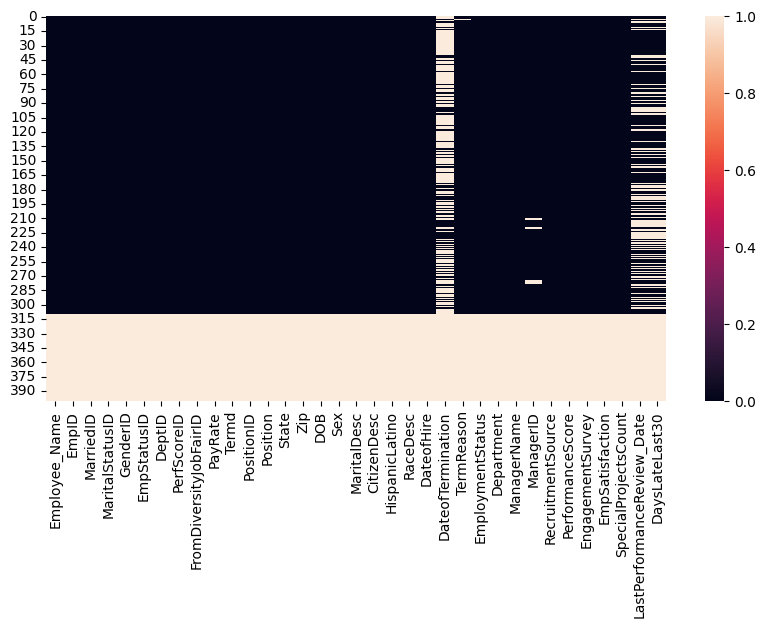

In [115]:
plt.figure(figsize=(10,5))
sns.heatmap(df_raw.isnull())
plt.show()

#### Typy danych

In [116]:
df_raw['ManagerName'].dtypes

dtype('O')

#### utworzenie kopii

In [117]:
df = df_raw[['EmpID', 'MarriedID', 'MaritalStatusID',
       'EmpStatusID', 'PerfScoreID', 'FromDiversityJobFairID',
       'DOB','Sex', 'MaritalDesc', 'Department',
       'DateofHire', 'DateofTermination', 'EmploymentStatus',
       'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount']].copy()

#### konwersja typów danych - daty

In [118]:
df['DOB'] = pd.to_datetime(df['DOB'],format='%m/%d/%y')
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'],format='%m/%d/%y')
df['DateofHire'] = pd.to_datetime(df['DateofHire'],format='%m/%d/%Y')

In [119]:
df['DOB'].head(10)[5:8]

5   1987-06-14
6   2064-06-01
7   2063-05-15
Name: DOB, dtype: datetime64[ns]

Daty urodzin zostały niepoprawnie przekształcone - niektóre z nich są z przyszłości

In [120]:
df.loc[(df['DOB'].dt.date > today), 
           ['DOB']] -= dt.timedelta(days=365.25*100)

In [121]:
df['DOB'].head(10)[5:8]

5   1987-06-14
6   1964-06-01
7   1963-05-15
Name: DOB, dtype: datetime64[ns]

Najpierw usuwamy wiersze bez żadnych danych.

In [122]:
df.dropna(axis=0, inplace=True, thresh=1)

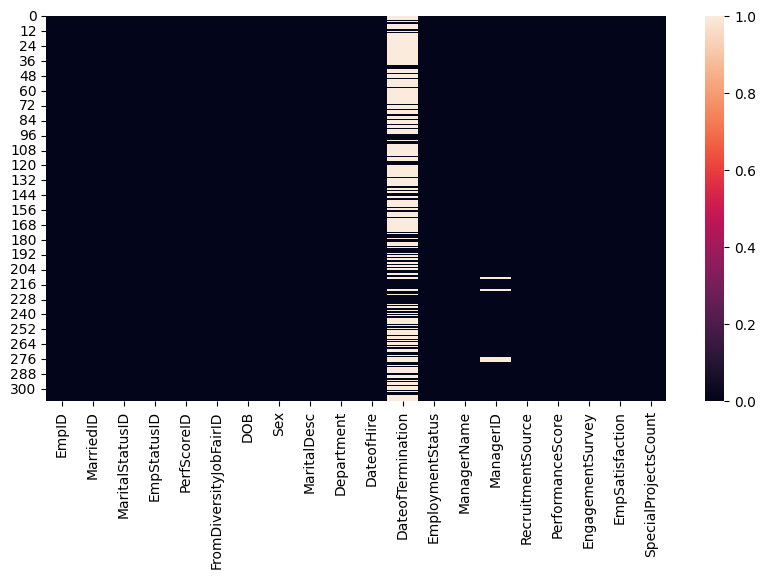

In [123]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()

Widać, że są menedżerowie, których nazwiska są znane, ale ID jest nieznane.

In [124]:
df.ManagerName.unique(), df.ManagerName.nunique()

(array(['Brandon R. LeBlanc', 'John Smith', 'Lynn Daneault',
        'Brian Champaigne', 'Jennifer Zamora', 'Janet King', 'Simon Roup',
        'Eric Dougall', 'Peter Monroe', 'Board of Directors', 'Amy Dunn',
        'Brannon Miller', 'David Stanley', 'Elijiah Gray', 'Kelley Spirea',
        'Ketsia Liebig', 'Kissy Sullivan', 'Michael Albert',
        'Webster Butler', 'Debra Houlihan', 'Alex Sweetwater'],
       dtype=object),
 21)

In [125]:
df.ManagerID.unique(), df.ManagerID.nunique()

(array([ 1., 17., 21., 13.,  5.,  2.,  4.,  6.,  7.,  9., 11., 12., 14.,
        16., 18., 19., 20., 22., 39., nan, 30., 15., 10.,  3.]),
 23)

In [126]:
df[['ManagerName', 'ManagerID']].groupby(['ManagerID']).value_counts()

ManagerID  ManagerName       
1.0        Brandon R. LeBlanc     6
2.0        Janet King            19
3.0        Brandon R. LeBlanc     1
4.0        Simon Roup            17
5.0        Jennifer Zamora        7
6.0        Eric Dougall           4
7.0        Peter Monroe          14
9.0        Board of Directors     2
10.0       Alex Sweetwater        9
11.0       Amy Dunn              21
12.0       Brannon Miller        21
13.0       Brian Champaigne       8
14.0       David Stanley         21
15.0       Debra Houlihan         3
16.0       Elijiah Gray          22
17.0       John Smith            14
18.0       Kelley Spirea         22
19.0       Ketsia Liebig         21
20.0       Kissy Sullivan        22
21.0       Lynn Daneault         13
22.0       Michael Albert        21
30.0       Michael Albert         1
39.0       Webster Butler        13
Name: count, dtype: int64

Okazuje się raczej, że są menedżerowie, którzy mają podwójne ID..

In [127]:
df[['ManagerName', 'ManagerID']].loc[df.ManagerID.isna() | df.ManagerName.isna()]

,ManagerName,ManagerID
210,Webster Butler,NaN
211,Webster Butler,NaN
220,Webster Butler,NaN
221,Webster Butler,NaN
275,Webster Butler,NaN
276,Webster Butler,NaN
277,Webster Butler,NaN
278,Webster Butler,NaN


In [128]:
df[['ManagerName']].loc[df.ManagerID.isna() | df.ManagerName.isna()]

,ManagerName
210,Webster Butler
211,Webster Butler
220,Webster Butler
221,Webster Butler
275,Webster Butler
276,Webster Butler
277,Webster Butler
278,Webster Butler


... a także są pracownicy przypisani do menedżerów, bez podania wartości ManagerID.\
Spróbujemy przyporządkować tym pracownikom odpowiednie ID managera

In [129]:
df.loc[df['ManagerName'] == 'Webster Butler', 'ManagerID'] = 39

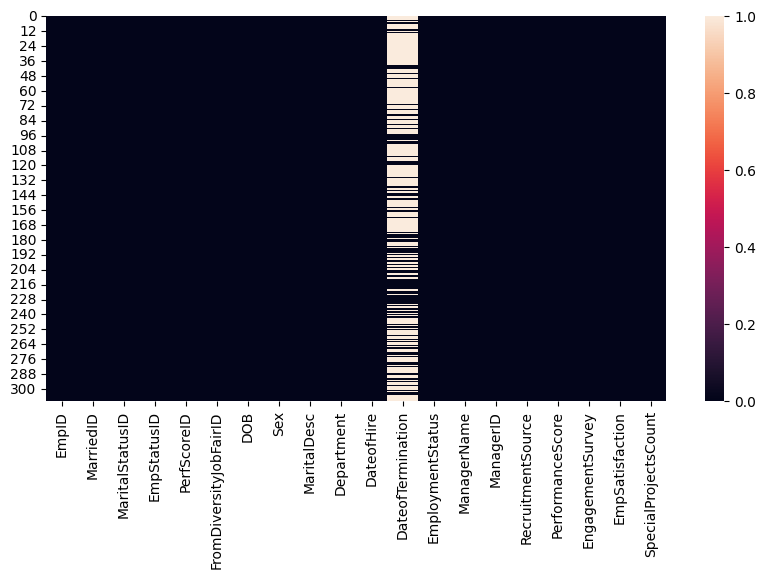

In [130]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()

**Czy istnieje zależność pomiędzy tym, kto jest bezpośrednim przełożonym (ManagerName, ManagerID) danego pracownika, \
a oceną wydajności pracy (PerformanceScore)?**

Tworzymy kopię danych potrzebnych do analizy

In [131]:
performance_df = df[['ManagerID', 'ManagerName', 'PerfScoreID', 'PerformanceScore']].copy()

In [132]:
perf_median = performance_df.PerfScoreID.median()
perf_average = performance_df.PerfScoreID.mean()

In [133]:
perf_analysis = performance_df[['ManagerName', 'PerfScoreID']].groupby(['ManagerName'], as_index=False).mean()
perf_analysis.rename({'PerfScoreID': 'score_avg'}, inplace=True, axis=1)

perf_analysis['under'] = performance_df[['ManagerName', 'PerfScoreID']].groupby(['ManagerName'], as_index=False).count()['PerfScoreID']
perf_analysis['score_max'] = performance_df[['ManagerName', 'PerfScoreID']].groupby(['ManagerName'], as_index=False).max()['PerfScoreID']
perf_analysis['score_min'] = performance_df[['ManagerName', 'PerfScoreID']].groupby(['ManagerName'], as_index=False).min()['PerfScoreID']

In [134]:
perf_analysis = perf_analysis.merge(
    performance_df[['ManagerName', 'PerfScoreID']]\
        .loc[performance_df['PerfScoreID']>perf_median]\
            .groupby(['ManagerName'], as_index=False)\
                .count(),
    on='ManagerName', how='left'
        ).rename({'PerfScoreID': 'above_median'}, axis=1)

perf_analysis = perf_analysis.merge(
    performance_df[['ManagerName', 'PerfScoreID']]\
        .loc[performance_df['PerfScoreID']<perf_median]\
            .groupby(['ManagerName'], as_index=False)\
                .count(),
    on='ManagerName', how='left'
        ).rename({'PerfScoreID': 'below_median'}, axis=1)
perf_analysis.fillna(0, inplace=True)

In [135]:
perf_analysis['above_median_perc'] = perf_analysis['above_median']/perf_analysis['under']
perf_analysis['below_median_perc'] = perf_analysis['below_median']/perf_analysis['under']

In [136]:
perf_analysis

,ManagerName,score_avg,under,score_max,score_min,above_median,below_median,above_median_perc,below_median_perc
0,Alex Sweetwater,3.111111,9,4.0,2.0,2.0,1.0,0.222222,0.111111
1,Amy Dunn,2.904762,21,4.0,1.0,3.0,3.0,0.142857,0.142857
2,Board of Directors,3.000000,2,3.0,3.0,0.0,0.0,0.000000,0.000000
3,Brandon R. LeBlanc,3.000000,7,3.0,3.0,0.0,0.0,0.000000,0.000000
4,Brannon Miller,2.904762,21,4.0,1.0,7.0,5.0,0.333333,0.238095
5,Brian Champaigne,3.000000,8,3.0,3.0,0.0,0.0,0.000000,0.000000
6,David Stanley,3.000000,21,4.0,2.0,1.0,1.0,0.047619,0.047619
7,Debra Houlihan,2.666667,3,3.0,2.0,0.0,1.0,0.000000,0.333333
8,Elijiah Gray,3.000000,22,4.0,2.0,2.0,2.0,0.090909,0.090909
9,Eric Dougall,3.250000,4,4.0,3.0,1.0,0.0,0.250000,0.000000


In [137]:
data_to_show = ['ManagerName', 'score_avg', 'above_median_perc', 'below_median_perc']

In [138]:
perf_analysis[data_to_show]\
    .style.background_gradient(cmap='PiYG', subset='score_avg')\
    .background_gradient(cmap='Oranges', subset='below_median_perc')\
    .background_gradient(cmap='Greens', subset='above_median_perc')\
        .format({'score_max': int,
                 'score_min': int,
                 'above_median': int,
                 'below_median': int,
                 'above_median_perc': '{:.0%}',
                 'below_median_perc': '{:.0%}'
                 })

,ManagerName,score_avg,above_median_perc,below_median_perc
0,Alex Sweetwater,3.111111,22%,11%
1,Amy Dunn,2.904762,14%,14%
2,Board of Directors,3.000000,0%,0%
3,Brandon R. LeBlanc,3.000000,0%,0%
4,Brannon Miller,2.904762,33%,24%
5,Brian Champaigne,3.000000,0%,0%
6,David Stanley,3.000000,5%,5%
7,Debra Houlihan,2.666667,0%,33%
8,Elijiah Gray,3.000000,9%,9%
9,Eric Dougall,3.250000,25%,0%


In [139]:
perf_analysis[['score_avg']].style.bar(subset='score_avg', color='lightgreen', align='zero')

,score_avg
0,3.111111
1,2.904762
2,3.000000
3,3.000000
4,2.904762
5,3.000000
6,3.000000
7,2.666667
8,3.000000
9,3.250000


Opis poprzez statystyki:

In [140]:
perf_analysis.score_avg.describe()

count    21.000000
mean      2.987200
std       0.137699
min       2.666667
25%       2.904762
50%       3.000000
75%       3.090909
max       3.250000
Name: score_avg, dtype: float64

In [141]:
performance_df.PerfScoreID.describe()

count    310.000000
mean       2.983871
std        0.577124
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: PerfScoreID, dtype: float64

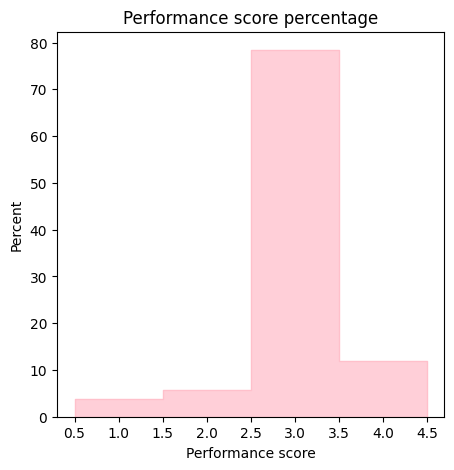

In [142]:
plt.figure(figsize=(5,5))
sns.histplot(data = performance_df, x='PerfScoreID', stat='percent',
             bins=4, binwidth=0.25, shrink=1, color='pink',
             kde=False, element='step', fill=True,
             discrete=True)
# performance_df['PerfScoreID'].hist(bins=4, density=True, align='mid', stacked=False)
plt.xlabel('Performance score')
plt.title('Performance score percentage')
plt.show()

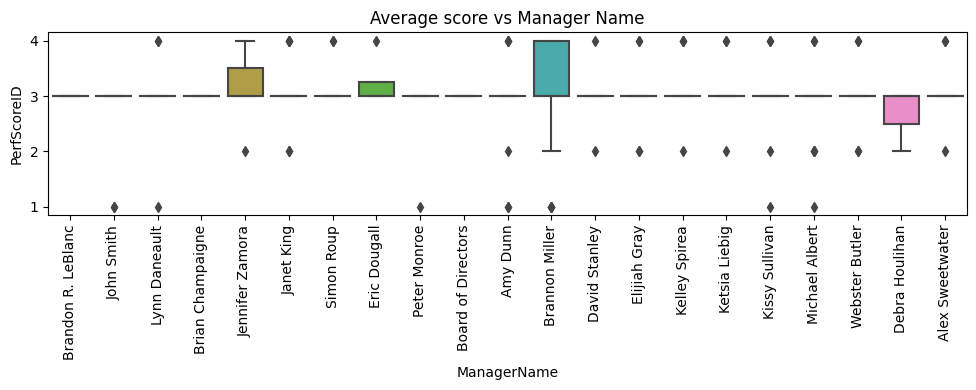

In [143]:
plt.figure(figsize=(10,4))
plt.title('Average score vs Manager Name', size=12)
sns.boxplot(y='PerfScoreID',x='ManagerName',data=performance_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Odpowiedź:**
* W analizie porównawczej średniego wyniku podwładnych poszczególnych menedźerów nie widać znaczących różnic pomiędzy nimi, wyniki są pomiędzy 2.67 a 3.25, odchylenie standardowe wynosi 0.14.
* Z dalszej analizy wynika, że:
    1. 33% pracowników menedżera o najsłabszym średnim wyniku (Debra) ma wynik poniżej mediany firmy, a 0% powyżej,
    2. W przypadku menedżera o najlepszym średnim wyniku (Eric) 25% ma wynik powyżej mediany, żaden z pracowników poniżej.
    3. Wymienieni menedżerowie wyróżniają się na wykresie pudełkowym.
    4. Na wykresie pudełkowym wyróżniają się również menedżerowie Jennifer i Brandon, ich średnie wyniki są dobre (3.14 i 2.90), jednak nie najlepsze.
* Trudno jednak stwierdzić, czy różnice te wynikają ze zdolności zarządzania menedżerów, czy z indywidualnych różnic pomiędzy pracownikami w poszczególnych zespołach.
* Analizę można by pogłębić sprawdzając statystyki dla poszczególnych działów.

**Jakie źródła pozyskania pracownika (Recruitment Source) są najlepsze, jeśli zależy nam na jak najdłuższym stażu pracowników?**
**

Obliczamy staż pracowników

In [144]:
def count_seniority(row):

    if pd.isnull(row['DateofTermination']):
        end_date = dt.datetime(today.year, today.month, today.day)
    else:
        end_date = row['DateofTermination']

    return (end_date - row['DateofHire'])/(365.25*np.timedelta64(1,'D'))

In [145]:
df['Seniority'] = df.apply(lambda row: count_seniority(row),axis=1).round(1)

In [146]:
df[['DateofHire','DateofTermination','Seniority']].head(5)

,DateofHire,DateofTermination,Seniority
0,2008-10-27,NaT,10.9
1,2014-01-06,NaT,5.7
2,2014-09-29,NaT,5.0
3,2015-02-16,2015-04-15,0.2
4,2015-05-01,NaT,4.4


Sporządzamy wykresy kolumnowe

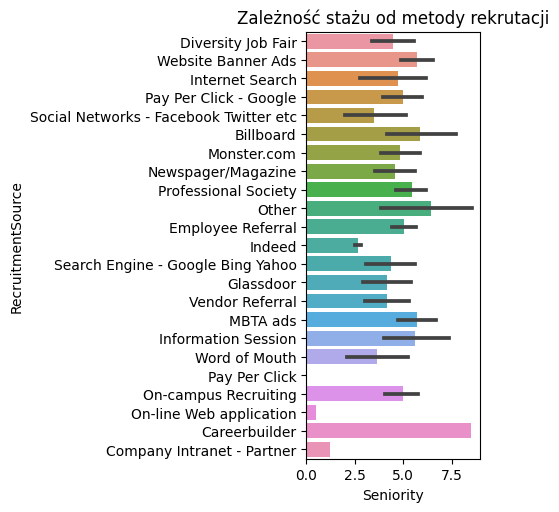

In [147]:
plt.figure(figsize=(5,5))
sns.barplot(data=df, y='RecruitmentSource', x='Seniority')
plt.tight_layout()
plt.title('Zależność stażu od metody rekrutacji')
plt.show()

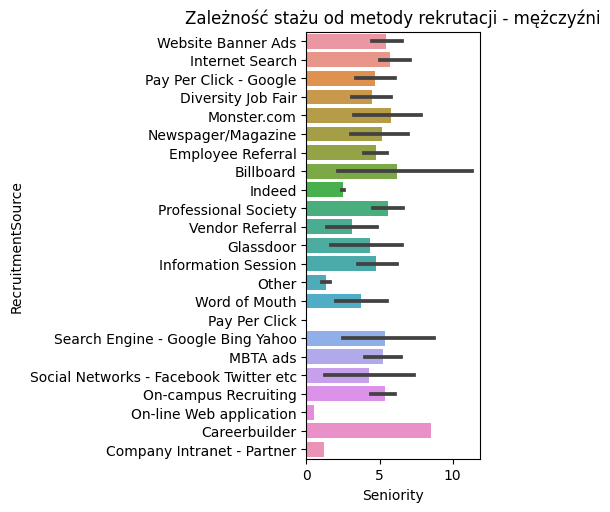

In [148]:
plt.figure(figsize=(5,5))
sns.barplot(data=df.loc[df['Sex']=='M '], y='RecruitmentSource', x='Seniority')
plt.tight_layout()
plt.title('Zależność stażu od metody rekrutacji - mężczyźni')
plt.show()

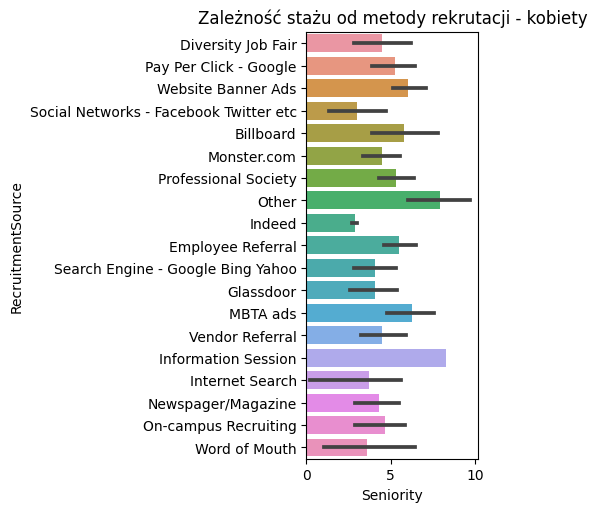

In [149]:
plt.figure(figsize=(5,5))
sns.barplot(data=df.loc[df['Sex']=='F'], y='RecruitmentSource', x='Seniority')
plt.tight_layout()
plt.title('Zależność stażu od metody rekrutacji - kobiety')
plt.show()

**Odpowiedź:**\
W analizie porównawczej zależności stażu pracy od metody rekrutacji można zauważyć, że globalnie najlepiej wypada Careerbuilder.\
Biorąc pod uwagę podział na płeć, dla mężczyzn wynik jest podobny jak globalny, w przypadku kobiet najlepsze wyniki dają Information Session oraz Other.

**Czy stan cywilny (MartialDesc) pracownika koreluje w jakikolwiek sposób z zadowoleniem z pracy (EmpSatisfaction)?**

In [150]:
df.MaritalDesc.unique(), \
    df.MaritalStatusID.unique(), \
        df.EmpSatisfaction.unique()

(array(['Married', 'Divorced', 'Single', 'Widowed', 'Separated'],
       dtype=object),
 array([1., 2., 0., 4., 3.]),
 array([2., 4., 5., 3., 1.]))

Tworzymy wykres kolumnowy

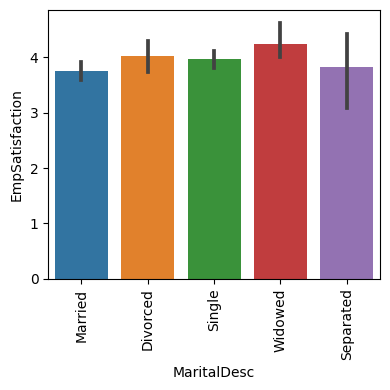

In [151]:
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='MaritalDesc', y='EmpSatisfaction')
plt.xticks(rotation=90)
plt.tight_layout()

**Odpowiedź:** z analizy nie wynika, by stan cywilny miał znaczący wpływ na poziom zadowolenia z pracy.

**Jak wygląda struktura wieku aktualnie zatrudnionych pracowników?**

In [152]:
df_raw.EmploymentStatus.unique()

array(['Active', 'Terminated for Cause', 'Voluntarily Terminated',
       'Future Start', 'Leave of Absence', nan], dtype=object)

In [153]:
age_df  = pd.DataFrame(df[['DOB','Department','SpecialProjectsCount']][df['EmploymentStatus'] == 'Active'].copy())

In [154]:
age_df['age'] = (np.datetime64(today)-age_df['DOB']).apply(lambda x: x/np.timedelta64(1,'D')/365.25).round(0)

In [155]:
age_df['age'].describe()

count    182.000000
mean      39.884615
std        8.368772
min       27.000000
25%       33.000000
50%       38.000000
75%       45.000000
max       69.000000
Name: age, dtype: float64

In [156]:
age_df.Department.unique()

array(['Admin Offices', 'Sales', 'IT/IS', 'Production       ',
       'Executive Office', 'Software Engineering'], dtype=object)

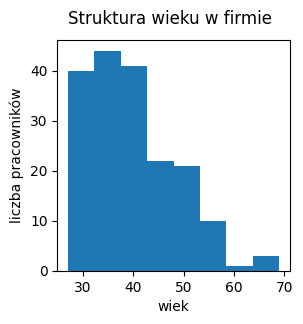

In [157]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(age_df['age'], bins=8)
ax.set_xlabel('wiek')
ax.set_ylabel('liczba pracowników')
fig.suptitle('Struktura wieku w firmie')
plt.show()

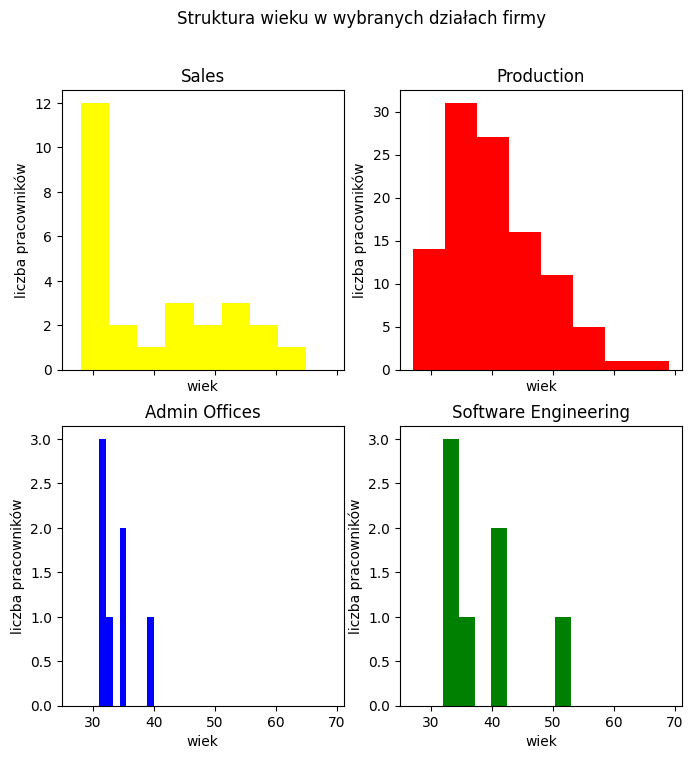

In [158]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(8,8))
ax[0,0].hist(age_df['age'].loc[age_df['Department']=='Sales'], bins=8, color='yellow')
ax[0,0].set_title('Sales')
ax[0,1].hist(age_df['age'].loc[age_df['Department']=='Production       '], bins=8, color='red')
ax[0,1].set_title('Production')
ax[1,0].hist(age_df['age'].loc[age_df['Department']=='Admin Offices'], bins=8, color='blue')
ax[1,0].set_title('Admin Offices')
ax[1,1].hist(age_df['age'].loc[age_df['Department']=='Software Engineering'], bins=8, color='green')
ax[1,1].set_title('Software Engineering')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('wiek')
        ax[i,j].set_ylabel('liczba pracowników')
fig.suptitle('Struktura wieku w wybranych działach firmy')
plt.show()

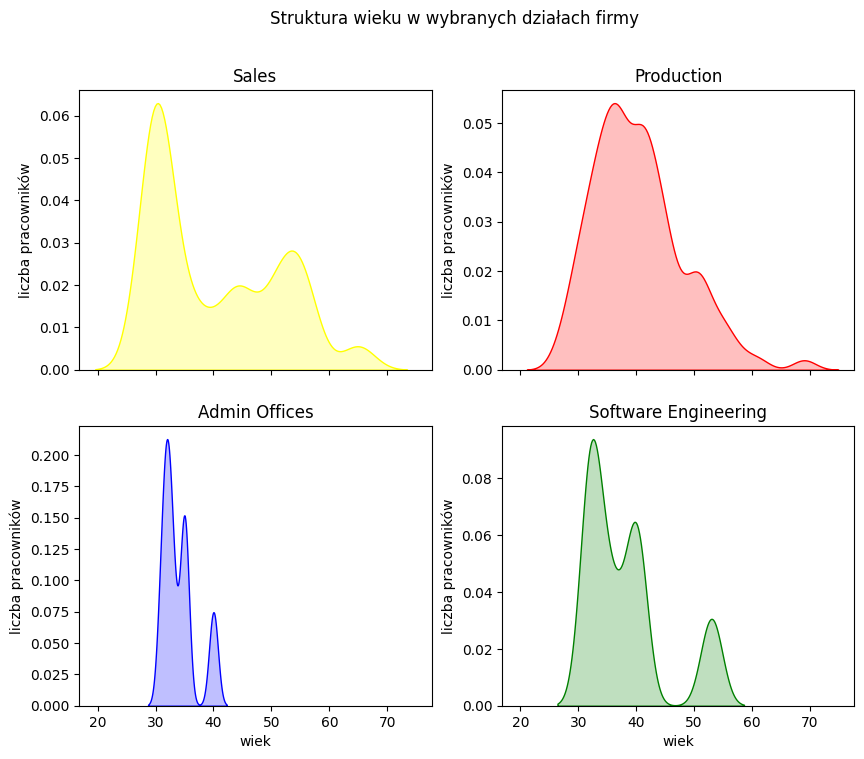

In [159]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(10,8))
sns.kdeplot(ax=ax[0,0], fill=True, bw_method=0.25, x= age_df['age'].loc[age_df['Department']=='Sales'], color='yellow')
ax[0,0].set_title('Sales')
sns.kdeplot(ax=ax[0,1], fill=True, bw_method=0.25, x= age_df['age'].loc[age_df['Department']=='Production       '], color='red')
ax[0,1].set_title('Production')
sns.kdeplot(ax=ax[1,0], fill=True, bw_method=0.25, x= age_df['age'].loc[age_df['Department']=='Admin Offices'], color='blue')
ax[1,0].set_title('Admin Offices')
sns.kdeplot(ax=ax[1,1], fill=True, bw_method=0.25, x= age_df['age'].loc[age_df['Department']=='Software Engineering'], color='green')
ax[1,1].set_title('Software Engineering')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('wiek')
        ax[i,j].set_ylabel('liczba pracowników')
fig.suptitle('Struktura wieku w wybranych działach firmy')
plt.show()

In [160]:
(age_df['age'].loc[age_df['Department']=='Production       '].count())/(age_df['age'].count())

0.5824175824175825

**Odpowiedź:**
* Srednia wieku pracowników wynosi 40 lat, najmłodszy ma lat 27, najstarszy 69.
* 75% pracowników nie jest starsza niż 45 lat.
* W działach Sales i Admin Offices przeważają młodzi pracownicy, na globalny rozkład wieku największy wpływ ma dział produkcji, prawdopodobnie dlatego, że jest tam zatrudnionych najwięcej pracowników (106 ze 182).

**Czy starsi pracownicy pracują nad większą liczbą specjalnych projektów niż młodsi pracownicy?**

<Figure size 400x400 with 0 Axes>

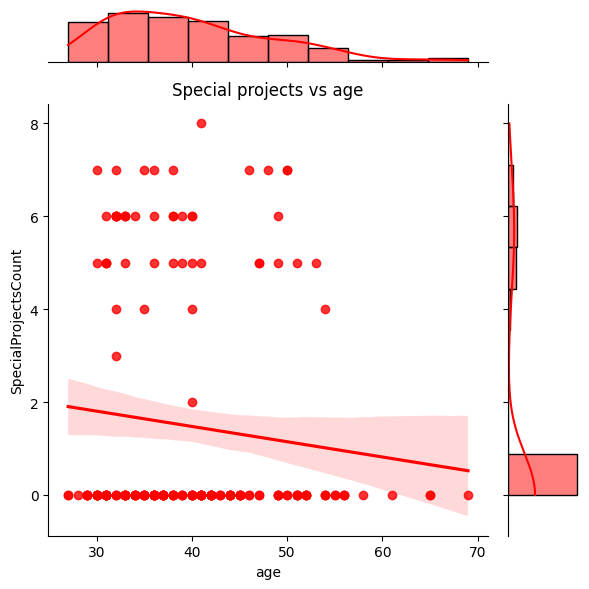

In [161]:
plt.figure(figsize=(4,4))

sns.jointplot(x='age',y='SpecialProjectsCount',data=age_df, kind='reg', color='red')
plt.title('Special projects vs age')
plt.tight_layout()
plt.show()

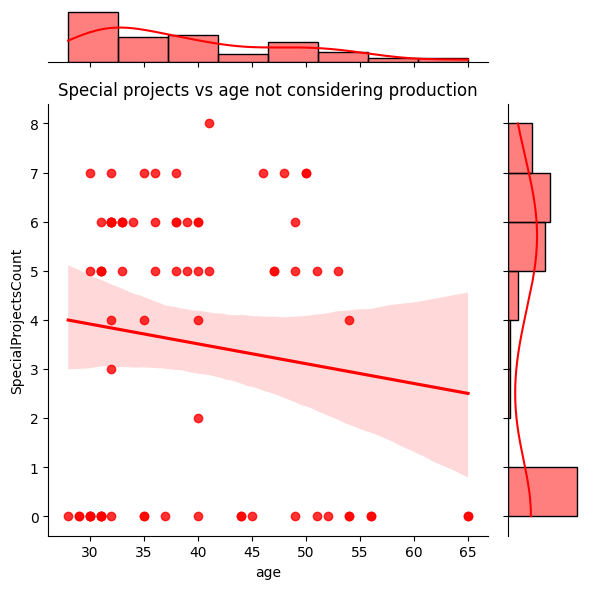

In [162]:
sns.jointplot(x='age',y='SpecialProjectsCount',data=age_df.loc[age_df['Department']!='Production       '], kind='reg', color='red')
plt.title('Special projects vs age not considering production')
plt.tight_layout()
plt.show()

Obliczmy jeszcze korelację:

In [163]:
age_df['SpecialProjectsCount']\
    .corr(age_df['age'], method='pearson')

-0.10820321071047596

In [164]:
age_df.loc[age_df['Department']!='Production       ']['SpecialProjectsCount']\
    .corr(age_df.loc[age_df['Department']!='Production       ']['age'], method='pearson')

-0.1279243166067007

In [165]:
age_df.loc[age_df['Department']=='IT/IS']['SpecialProjectsCount']\
    .corr(age_df.loc[age_df['Department']=='IT/IS']['age'], method='pearson')

-0.11844746601320788

**Odpowiedź:**\
Z analizy danych wynika, że wiek ujemnie koreluje z liczbą specjalnych projektów.\
Korelacja ta jest jednak nieznaczna (rzędu 10%)